## Analytics Case: StudyPerfetti van Melle

#### Assumptions

- Volume of production is in tonnes.
- All country/Regions (eg CZ_SK, CEE_CZ_SLO_SK, I etc) groupings not provided are grouped as 'OTHERS'

In [188]:
# Import necessary libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import zscore

In [189]:
# The extracted data was used for further PowerBI project
def extract_top_sku_by_region(file_path, output_path=None):
    """
    Extract the first five rows with the max SKU values for each unique 'Region' in an Excel file.
    
    Parameters:
    file_path (str): Path to the input Excel file.
    output_path (str, optional): Path to save the output Excel file. If None, the result will not be saved.
    
    Returns:
    pd.DataFrame: DataFrame containing the top 5 SKU values for each unique 'Region'.
    """
    # Load the Excel file into a pandas DataFrame
    df = pd.read_excel(file_path)
    
    # FOR POWER BI
    # Sort the DataFrame by 'Region' and 'SKU' in descending order
    df_sorted = df.sort_values(by=['Region', 'TotalVolume'], ascending=[True, False])

    # Extract the first 5 rows with max SKU values for each unique 'Region'
    df_top_products = df_sorted.groupby('Region').head(5)

    # Save the result to an Excel file if output_path is provided
    if output_path:
        df_top_products.to_excel(output_path, index=False)

    return df, df_top_products

# Call function
file_path = './Data/TableByRegion&SKU.xlsx'  
output_path = 'top_5_products_by_region.xlsx' 
# df, top_products_df = extract_top_sku_by_region(file_path, output_path)

# Print the resulting DataFrame
# top_products_df.head()

## Forecasting Model

#### Load & Process Data

In [190]:
def load_and_process_data(file_path):
    """
    Load a CSV file, convert the 'Date' column to datetime format,
    and rename the 'Volume Production' column to 'Volume of Production'.
    
    Parameters:
    - file_path: str, the path to the CSV file
    
    Returns:
    - DataFrame: processed DataFrame with the desired format
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Convert the 'Date' column from string format to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Rename the column 'Volume Production' to 'Volume of Production'
    df.rename(columns={'Volume Production': 'Volume of Production'}, inplace=True)
    df['SKU'] = df['SKU'].astype('object')
    
    return df

file_path = './Data/Case_Study_Data_Grouped.csv'
df = load_and_process_data(file_path)

# Display the first few rows of the processed DataFrame
df.head()

,Country/Region,SKU,SKU Description,Volume of Production,Date
0,Austria,1573003,C SHOCK MNO JUMPING STRAWB NEW AU DE HU,0.0000,2021-07-01
1,Austria,1573003,C SHOCK MNO JUMPING STRAWB NEW AU DE HU,0.0000,2021-08-01
2,Austria,1573003,C SHOCK MNO JUMPING STRAWB NEW AU DE HU,0.0000,2022-01-01
3,Austria,1573003,C SHOCK MNO JUMPING STRAWB NEW AU DE HU,0.0000,2022-04-01
4,Austria,1573003,C SHOCK MNO JUMPING STRAWB NEW AU DE HU,0.8712,2022-02-01


#### Exploratory Data Analysis

In [191]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7449 entries, 0 to 7448
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Country/Region        7449 non-null   object        
 1   SKU                   7449 non-null   object        
 2   SKU Description       7449 non-null   object        
 3   Volume of Production  7449 non-null   float64       
 4   Date                  7449 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 291.1+ KB


Data is complete and features with correct datatypes.

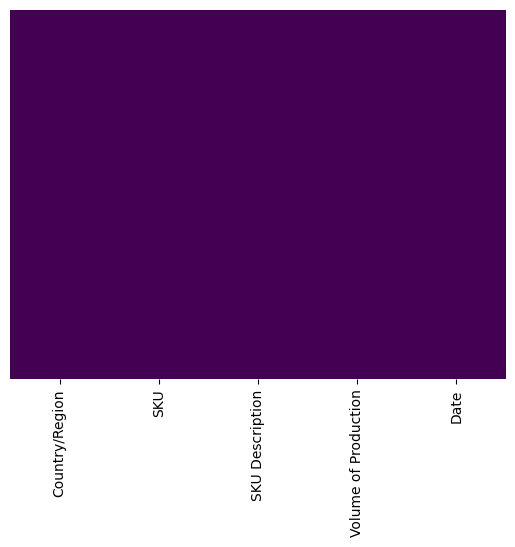

In [192]:
# Check Missing Values In Each Column
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

No missing values. Yellow would have indicated missing values

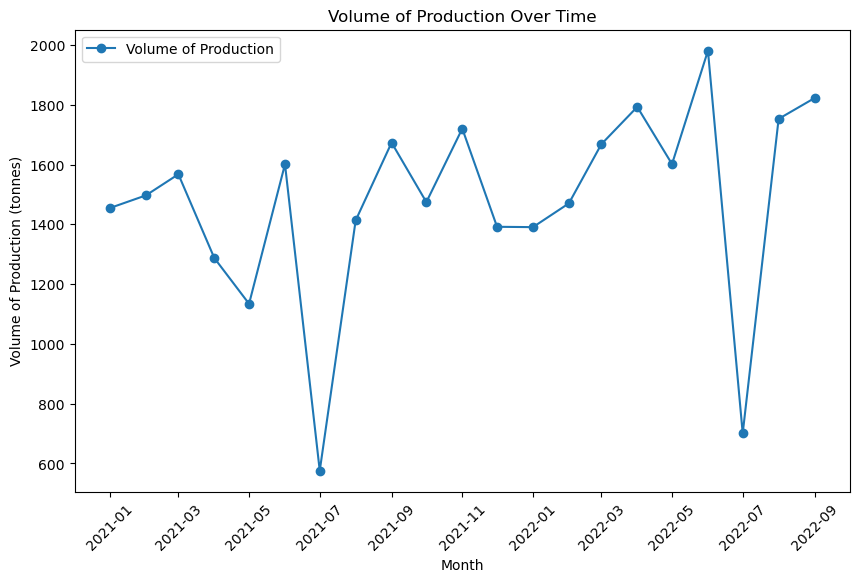

In [193]:
# Time series plot
def aggregate_and_plot_volume(df):
    """
    Aggregate 'Volume of Production' across all countries and SKUs by date
    and plot the results.
    
    Parameters:
    - df: DataFrame containing the 'Date' and 'Volume of Production' columns
    """
    # Aggregate 'Volume Production' across all countries and SKUs by month
    agg_data = df.groupby('Date')['Volume of Production'].sum().reset_index()

    # Create a plot for the aggregated data
    plt.figure(figsize=(10, 6))
    plt.plot(agg_data['Date'], agg_data['Volume of Production'], marker='o', label='Volume of Production')

    # Label the chart
    plt.title('Volume of Production Over Time')
    plt.xlabel('Month')
    plt.ylabel('Volume of Production (tonnes)')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.legend()

    # Display the plot
    plt.show()

    return agg_data

# Call the function to aggregate and plot the volume of production
agg_data =  aggregate_and_plot_volume(df)

This graph shows the monthly production from Jan.2021 to Sept.2022. It shows that the lowest production happened in **July 2021** and **July 2022**, while the highest was in **June 2022**. Although there are some big drops in production, especially around these months, the production quickly recovers, reaching higher levels afterward. Overall, the trend shows that while production varies, it tends to bounce back and grow over time.



#### Normality Test

In [194]:
def test_normality(dataframe, column_name, alpha=0.005):
    """
    Perform the Shapiro-Wilk test for normality on a specified column of a DataFrame.

    Parameters:
    - dataframe: pd.DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column to test for normality.
    - alpha: float
        The significance level for the test (default is 0.05).

    Returns:
    - stat: float
        The test statistic from the Shapiro-Wilk test.
    - p: float
        The p-value from the Shapiro-Wilk test.
    """
    # Select the specified column
    data = dataframe[column_name]
    
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(data)
    
    # Print the results of the test
    print(f'Shapiro-Wilk test statistic = {stat:.2f} and p-value = {p:.4f}')
    
    # Interpret the results
    if p > alpha:
        print('The data set looks normally distributed.')
    else:
        print('The data set does not look normally distributed.')

    return stat, p

# Call function
stat, p = test_normality(agg_data, 'Volume of Production')

Shapiro-Wilk test statistic = 0.88 and p-value = 0.0139
The data set looks normally distributed.


#### Skewness Test

In [195]:
def calculate_skewness(dataframe, column_name):
    """
    Calculate and interpret the skewness of a specified column in a DataFrame.

    Parameters:
    - dataframe: pd.DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column for which to calculate skewness.

    Returns:
    - skewness_value: float
        The skewness value of the specified column.
    """
    # Calculate skewness
    skewness_value = skew(dataframe[column_name])
    
    # Print the skewness value
    print(f"Skewness of '{column_name}': {skewness_value:.2f}")
    
    # Interpretation based on skewness value
    if skewness_value > 0.5:
        print("The data is positively skewed.")
    else:
        print("The data is approximately symmetric.")

    return skewness_value

# Call function
skewness_value = calculate_skewness(agg_data, 'Volume of Production')

Skewness of 'Volume of Production': -1.28
The data is approximately symmetric.


#### Outlier Test

In [196]:
def detect_outliers(dataframe, column_name, threshold=3):
    """
    Detect outliers in a specified column of a DataFrame using Z-scores.

    Parameters:
    - dataframe: pd.DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column to check for outliers.
    - threshold: float
        The Z-score threshold for identifying outliers (default is 3).

    Returns:
    - outliers: pd.DataFrame
        A DataFrame containing the outliers.
    """
    # Calculate Z-scores
    dataframe['zscore'] = zscore(dataframe[column_name])
    print(f"Z-scores calculated for column '{column_name}'.")

    # Identify outliers based on Z-score threshold
    outliers = dataframe[dataframe['zscore'].abs() > threshold]
    print(f"Identified {len(outliers)} outliers in column '{column_name}' with Z-score threshold of {threshold}.")

    return outliers

# Call function
outliers = detect_outliers(agg_data, 'Volume of Production')
# print(outliers)


Z-scores calculated for column 'Volume of Production'.
Identified 0 outliers in column 'Volume of Production' with Z-score threshold of 3.


The data is Normally distributed, not positivley skewed and has no outlier. This makes it fit to be used to build forecast model.

#### Forecasting the overall production for the next 3 months (across all countries and regions)

#### Forecast With Polynomial Linear Regression

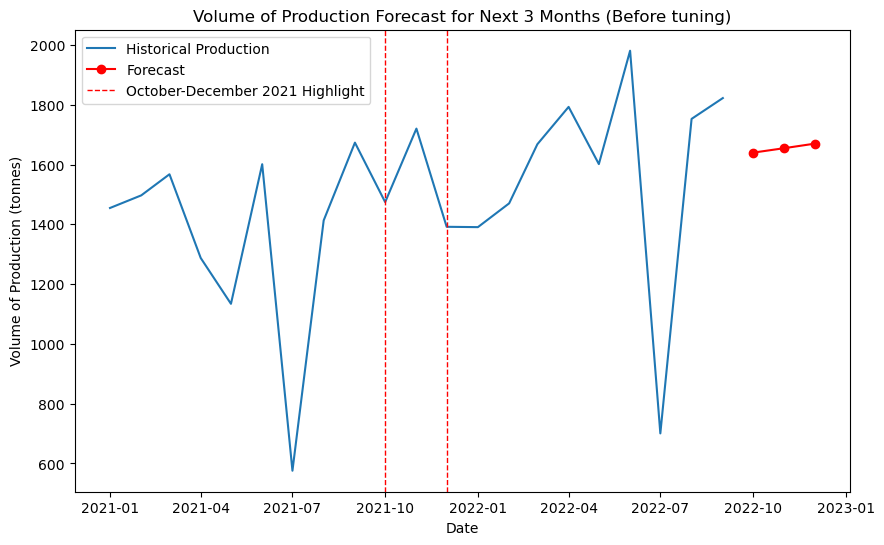

  Forecast Date  Volume of Production
0    2022-10-01           1639.706969
1    2022-11-01           1654.709886
2    2022-12-01           1669.712803


In [197]:
def polynomial_regression_forecast(df, n_periods=3, degree=2, include_bias=True, interaction_only=True, title="Volume of Production Forecast for Next 3 Months (Before tuning)"):
    """
    Perform polynomial regression forecasting on the volume of production data.
    
    Parameters:
    - df: DataFrame containing the 'Date' and 'Volume of Production' columns
    - n_periods: int, the number of future periods to forecast
    - degree: int, the degree of the polynomial regression model
    - include_bias: bool, whether to include a bias term in the polynomial features
    - interaction_only: bool, whether to include only interaction features
    - title: str, the title of the plot
    
    Returns:
    - forecast_df: DataFrame containing forecasted values and their dates
    """
    # Create a new column 'Time' representing the number of months since the first data point
    df['Time'] = np.arange(len(df))

    # Set up Polynomial Regression model with specified degree and additional parameters
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias, interaction_only=interaction_only)  # Create polynomial features
    X_poly = poly.fit_transform(df[['Time']])  # Transform the 'Time' column

    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, df['Volume of Production'])

    # Forecast for the next n_periods months
    last_time_point = df['Time'].iloc[-1]
    future_times = np.arange(last_time_point + 1, last_time_point + n_periods + 1).reshape(-1, 1)

    # Transform future times into polynomial features
    future_times_poly = poly.transform(future_times)

    # Predict the production for the next n_periods
    forecast = model.predict(future_times_poly)

    # Create future dates for the next n_periods
    forecast_dates = pd.date_range(start=df['Date'].iloc[-1], periods=n_periods + 1, freq='MS')[1:]

    # Plot the historical data and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Volume of Production'], label='Historical Production')
    plt.plot(forecast_dates, forecast, label='Forecast', color='red', marker='o')
    
    # Adding the dotted red line between October 2021 and December 2021 with a label
    plt.axvline(pd.to_datetime('2021-10-01'), color='red', linestyle='--', linewidth=1, label='October-December 2021 Highlight')  # Vertical line for October 2021 with label
    plt.axvline(pd.to_datetime('2021-12-01'), color='red', linestyle='--', linewidth=1)  # Vertical line for December 2021

    plt.title(title)  # Dynamic title based on input
    plt.xlabel('Date')
    plt.ylabel('Volume of Production (tonnes)')
    plt.legend()
    
    plt.show()

    # Display the forecasted values
    forecast_df = pd.DataFrame({
        'Forecast Date': forecast_dates,
        'Volume of Production': forecast
    })

    return forecast_df

# Example call with a custom title
forecast_df = polynomial_regression_forecast(agg_data)

# Display the forecasted DataFrame
print(forecast_df)

- The graph shows both the historical production volumes and a forecast for the next three months before tuning the hyperparameters. 

- It shows that the production in the past has fluctuated, with some notable dips and rebounds. `For the upcoming months of October, November, and December 2022, the forecast suggests a steady increase in volume of production, starting at about 1639.71 tonnes in October, rising to 1654.71 tonnes in November, and reaching 1669.71 tonnes by December.` The forecast indicates a positive trend, with production expected to grow as we approach the end of the year.

#### Model Evaluation & Hyperparameter Tuning On Historical Data


Polynomial Model (before tuning) - Mean Absolute Percentage Error (MAPE): 42.78%
Best Parameters: {'poly__degree': 3, 'poly__include_bias': False, 'poly__interaction_only': False}
Polynomial Model (after tuning) - Mean Absolute Percentage Error (MAPE): 37.78%


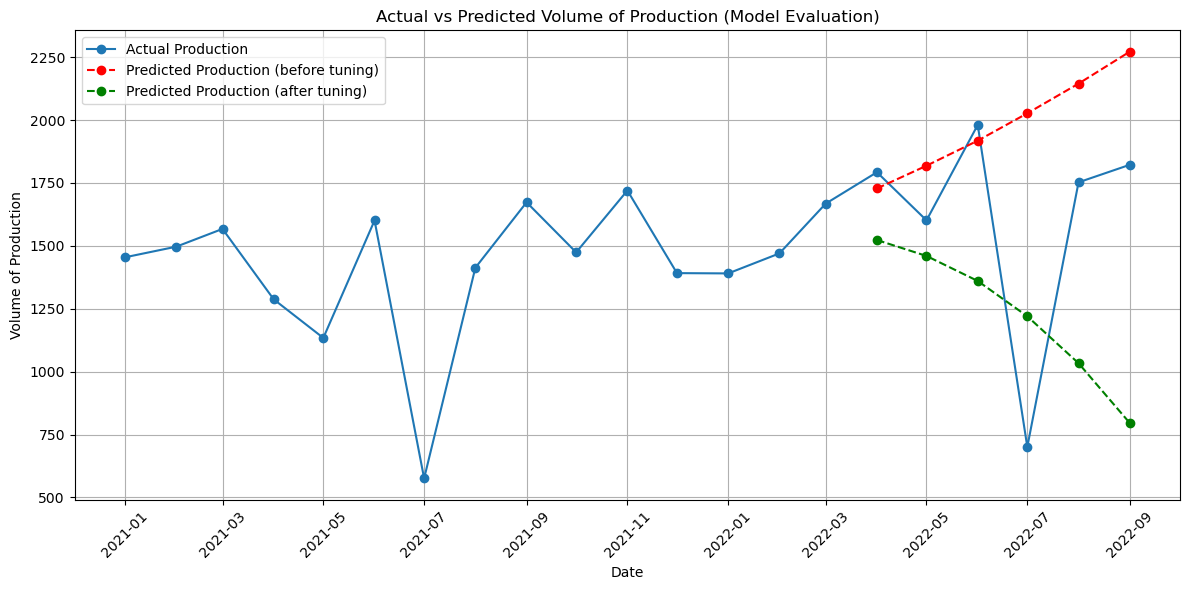

In [198]:
def tuning_and_evaluation(df, test_size=6):
    """
    Perform polynomial regression with hyperparameter tuning on the volume of production data.
    
    Parameters:
    - df: DataFrame containing the 'Date' and 'Volume of Production' columns
    - test_size: int, the number of months to use for testing
    
    Returns:
    - None
    """
    # Create 'Time' column representing months since first data point
    df['Time'] = np.arange(len(df))

    # Split data into training and testing sets
    train = df.iloc[:-test_size]
    test = df.iloc[-test_size:]

    # Prepare features (Time) and target (Volume Production) for both sets
    X_train = train[['Time']]
    y_train = train['Volume of Production']
    X_test = test[['Time']]
    y_test = test['Volume of Production']

    # Fit a Polynomial Regression model before tuning (default degree)
    poly_default = PolynomialFeatures(degree=2)  # Default degree
    X_train_poly_default = poly_default.fit_transform(X_train)

    # Fit the model
    model_default = LinearRegression()
    model_default.fit(X_train_poly_default, y_train)

    # Predict on the test set using the default polynomial model
    y_pred_poly_default = model_default.predict(poly_default.transform(X_test))

    # Evaluate the default polynomial model using MAPE
    mape_poly_default = mean_absolute_percentage_error(y_test, y_pred_poly_default) * 100  # Convert to percentage
    print(f'Polynomial Model (before tuning) - Mean Absolute Percentage Error (MAPE): {mape_poly_default:.2f}%')

    # Set up the parameter grid for hyperparameter tuning
    param_grid = {
        'poly__degree': [1, 2, 3, 4, 5],        # Test polynomial degrees from 1 to 5
        'poly__interaction_only': [False, True], # Include interaction terms
        'poly__include_bias': [True, False]      # Include bias term
    }

    # Create a polynomial feature transformer
    poly = PolynomialFeatures()

    # Create a Linear Regression model
    model = LinearRegression()

    # Combine polynomial feature transformation and linear regression into a pipeline
    pipeline = Pipeline(steps=[('poly', poly), ('linear_reg', model)])

    # Set up GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the corresponding model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Predict on the test set using the best model
    y_pred_poly_tuned = best_model.predict(X_test)

    # Evaluate the tuned polynomial model using MAPE
    mape_poly_tuned = mean_absolute_percentage_error(y_test, y_pred_poly_tuned) * 100  # Convert to percentage
    print(f'Best Parameters: {best_params}')
    print(f'Polynomial Model (after tuning) - Mean Absolute Percentage Error (MAPE): {mape_poly_tuned:.2f}%')

    # Plot actual vs predicted for both polynomial models
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume of Production'], label='Actual Production', marker='o')
    plt.plot(test['Date'], y_pred_poly_default, label='Predicted Production (before tuning)', color='red', marker='o', linestyle='--')
    plt.plot(test['Date'], y_pred_poly_tuned, label='Predicted Production (after tuning)', color='green', marker='o', linestyle='--')
    plt.title('Actual vs Predicted Volume of Production (Model Evaluation)')
    plt.xlabel('Date')
    plt.ylabel('Volume of Production')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function to perform polynomial regression with tuning
tuning_and_evaluation(agg_data)

- The result shows that the best parameters for the model after tuning on historical data are: {'poly__degree': 3, 'poly__include_bias': False, 'poly__interaction_only': False}.

- The graph compares actual production volumes with predicted production from two polynomial models. The `blue dots` represent the actual production data from January 2021 to September 2022, while the `red dashed line` shows the predictions from the model before tuning, which had a Mean Absolute Percentage Error (MAPE) of **42.78%**. 

- The `green dashed line` represents the predictions from a tuned polynomial model, which improved accuracy, achieving a lower MAPE of **37.78%**.

- `The MAPE of 37.78% for example indicates that, on average, our predictions for production volume are off by about 38%. This means that if we forecast that we will produce 100 tonnes, we might actually produce between 62 and 138 units.` A MAPE this high suggests that our forecasting model has room for improvement, as accurate predictions are crucial for managing resources and meeting demand effectively.  

- While both models track the actual production to some extent, the tuned model provides a closer fit to the data, indicating it may better account for the complexities and fluctuations in production volumes over time.

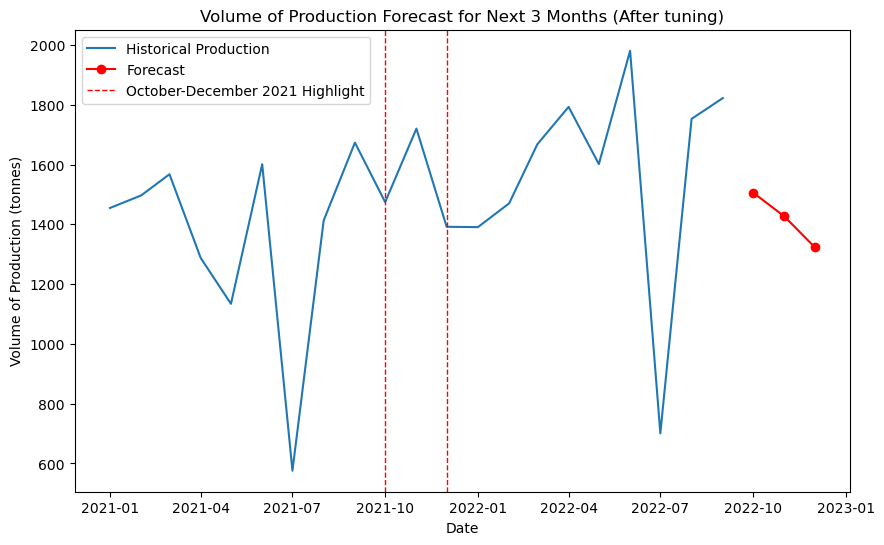

  Forecast Date  Volume of Production
0    2022-10-01           1506.060198
1    2022-11-01           1426.669792
2    2022-12-01           1323.955391


In [199]:
# Call function with tuned parameters
forecast_df = polynomial_regression_forecast(agg_data, n_periods=3, degree=3, include_bias=False, interaction_only=False, title="Volume of Production Forecast for Next 3 Months (After tuning)")

# Display the forecasted DataFrame
print(forecast_df)

- The graph shows both the historical production volumes and a forecast for the next three months after tuning the hyperparameters. 

- `It shows that for the upcoming months of October, November, and December 2022, the forecast suggests a steady decrease in production, starting at 1506.06 tonnes in October, reducing to 1426.67 tonnes in November, and then to 1323.96 tonnes by December.` The forecast indicates a negative trend, with production expected to decline as we approach the end of the year.

- I would have expected the forecast curve for the three months to follow same trend as observed in the same months of previous year (see red vertical dottedlines) since both years generally follow similar patterns. However, this is not the case given the MAPE is about 38%.



#### Result

- The forecasting outcome for the overall production for the next 3 months (across all countries and regions) are:

   - October: 1506.06 tonnes 
   - November: 1426.67 tonnes, and 
   - December: 1323.96 tonnes 

#### In conclusion

- The historical data used in this study doesn't cover multiple years, so the forecast model doesn't have enough data to learn meaningful monthly/yearly seasonality. With only 21 data points when aggregated by month, you have very limited historical data. This might make it challenging for any forecasting model to learn meaningful trends or seasonal patterns. Forecaast models typically require larger datasets in order to capture (complex) seasonality patterns over longer periods.

- To better understand and study the dips and peaks in the historical curve, additional data such as holidays and external regressors (eg Competitor Pricing and Promotions, Raw Material Availability and Costs, Supply Chain Disruptions etc) patterns would need to be considered, as most forecast models typically expects. By incorporating these variables, it would be easier to capture the seasonal effects and trends, helping to better explain variations in production.